# Preparing resnet34 for Hailo-8

This notebook quantizes the resnet34 model previously saved in the MODEL_ORIG_HAR file.  

For calibration, a set of at least 1024 images must be provided. Please set the below variable IMAGE_DIR accordingly.
The PC must have a GPU in order to enable the default optimization level 1. For full information see the Dataflow Compiler user guide / Model optimization section.

For higher fps, uncomment the line

<i> 'model_optimization_flavor(optimization_level=2, compression_level=4, batch_size=2)\n' </i>


---
***Change log***

Jul 1, 2022: 
- Updated for DFC 3.18
- Now at least 1024 images must be provided for calibration
June 24, 2022:
- Added code get the number of *.jpg files in directory IMAGE_DIR in case quantization fine tune is alter needed. For now keep MX_NUM_IMAGES=64
- Bug fix: make sure to call runner.load_model_script() to pass model script file 'model.alls'. Previously this call was missing.
- Simplified the 'model.alls' file

June 21, 2022: First version created

---

In [1]:
from pathlib import Path
import os
import fnmatch

MODEL      = 'resnet34'

INPUT_WIDTH= 150
INPUT_HEIGHT= 150

# Set IMAGE_DIR to point to your input *.jpg images which will be used for calibration
HOME_DIR = str(Path.home())
WORKDIR= str(Path.cwd())
#IMAGE_DIR = HOME_DIR + '/workspace/datasets/coco/val2017'
IMAGE_DIR = WORKDIR + '/lp_data_cropped'
# Set max number of images used for calibration
MAX_NUM_IMAGES= len(fnmatch.filter(os.listdir(IMAGE_DIR), '*.jpg'))
#MAX_NUM_IMAGES= 64
print('The dataset has ' + str(MAX_NUM_IMAGES) + ' images')

MODEL_ORIG_HAR= MODEL + '_orig.har'

The dataset has 1200 images


In [2]:
# Find Virtual environment path
import subprocess as sp
python3Path = sp.getoutput('which python3')
endPos= python3Path.find("/bin/python3")
if (endPos== -1):
    print ("Error could not find virtualenv path")
else:
    VENV_PATH= python3Path[0:endPos]
print("Virtual environment located at " + VENV_PATH)
        

Virtual environment located at /home/victorc/workspace/hailo_sw_suite/hailo_venv


In [3]:
import tensorflow as tf
import numpy as np
from hailo_sdk_client import ClientRunner, __version__, NNFramework
from hailo_sdk_common.preprocessing import Normalization

In [4]:
print('TF version:', tf.__version__)
print('Hailo DFC version', __version__)

TF version: 2.5.2
Hailo DFC version 3.18.1


### Quantizing the model

For simplicity, in this case we're going to have a false quantization. This will NOT produce real results, until quantizing with real data

In [5]:
import PIL
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [6]:
runner = ClientRunner(hw_arch='hailo8', har_path=MODEL_ORIG_HAR)

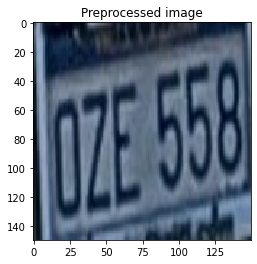

In [7]:
def convert_rgb_to_yuv(image):
    transition_matrix = np.array([[0.2568619, -0.14823364, 0.43923104],
                                  [0.5042455, -0.2909974, -0.367758],
                                  [0.09799913, 0.43923104, -0.07147305]])
    image = np.matmul(image, transition_matrix)
    image += [16, 128, 128]
    return image

def preproc_resize(path):  
    pil_image = Image.open(path)
    ip = pil_image.resize([INPUT_WIDTH, INPUT_HEIGHT])
    ip = np.array(ip)
    return ip

files = os.listdir(IMAGE_DIR)
files.sort()
files = files[0:MAX_NUM_IMAGES]
idx= 0
calib_dataset = np.zeros((len(files), INPUT_HEIGHT, INPUT_WIDTH, 3), dtype=np.float32)
for filename in files:
    if(os.path.isfile(os.path.join(IMAGE_DIR, filename)) and ('.jpg' in filename)):
        img_preproc= preproc_resize(os.path.join(IMAGE_DIR,filename))
        calib_dataset[idx,:,:,:] = img_preproc.astype(np.uint8)
        idx=idx+1
        
plt.imshow(np.array(calib_dataset[idx-1,:,:,:], np.uint8), interpolation='nearest')
plt.title('Preprocessed image')
plt.show()

In [8]:
alls_lines = [
    'normalization_input = normalization([0.0, 0.0, 0.0], [255.0, 255.0, 255.0])\n',
    'quantization_param(fc1, precision_mode=a8_w4)\n'
    # 'allocator_param(automatic_ddr= False )\n', # Recommended for running on system with 1 or 2 PCIe lanes
    # -- Below reduces weights memory by 80% for higher fps with optimization level=2 to improve accuracy
    # Recommend to have GPU for reduced optimization time
    #'model_optimization_flavor(optimization_level=1, compression_level=3, batch_size=2)\n'  # Batch size is 8 by default, adjust it according to GPU memory
]

open('model.alls','w').writelines(alls_lines)


In [9]:
runner.load_model_script('model.alls')

runner.optimize(calib_dataset)

MODEL_QUANTIZED_HAR= MODEL + '_quantized.har'
runner.save_har(MODEL_QUANTIZED_HAR)

[info] Loading model script on resnet34 from model.alls
[info] Adding normalization layers
[info] Starting Quantization
[info] Using data type np_array for dataset
[warning] Reducing optizmiation level to 0 (the accuracy won't be optimized) because there's no available GPU
[info] Using a calibration set of 64 entries for quantization
[info] Creating graph from hn
[info] Loading model configuration from config_file
[info] Loading params from npz
[info] Starting Equalization
[info] Creating graph from hn
[info] Loading model configuration from config_file
[info] Loading params from npz
[info] Equalization configuration:
[info]     Default policy: enabled
[info]     Mode: min_based
[info] Starting Equalization of component 1 out of 1
[info] The time for equalization 00:00:03.41
[info] Equalization is done
[info] Starting weights clipping
[info] Translating params for resnet34
[info] Creating graph from hn
[info] Loading model configuration from config_file
[info] Loading params from npz
[